In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from skimage.draw import disk
from skimage.segmentation import flood_fill
from skimage.segmentation import find_boundaries
from skimage.draw import polygon
from scipy.ndimage import binary_dilation
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Open the .mat file using h5py
# mat_file = h5py.File(r'C:\Users\hites\OneDrive\Desktop\machine learning\Brain Tumor Datasets-2\Brain Tumor Datasets\Dataset 3\Dataset 3\brainTumorDataPublic_1-766\1.mat', 'r')

# List all available dataset names in the file
# print(list(mat_file.keys()))

# Close the file
# mat_file.close()

# Define the directory containing the .mat files
directory = [r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_1-766'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_767-1532'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_1533-2298'
            ,r'/content/drive/MyDrive/breatcancer/brainTumorDataPublic_2299-3064']

# Create a list to store the loaded data from all files
all_data = []
segmented_tumor_data=[]
# Iterate through the .mat files in the directory
for each_dir in directory:
    for filename in os.listdir(each_dir):
        if filename.endswith('.mat'):
            # Construct the full file path
            file_path = os.path.join(each_dir, filename)

            # Load the .mat file using h5py
            with h5py.File(file_path, 'r') as file:
                # Access the data fields within the HDF5 dataset
                label = file['cjdata']['label'][0, 0]
                patient_id = file['cjdata']['PID'][:]
                image_data = file['cjdata']['image'][:]
                tumor_border = file['cjdata']['tumorBorder'][:]
                tumor_mask = file['cjdata']['tumorMask'][:]
                segmented_tumor_data.append(np.where(tumor_mask == 1,image_data, 0))

                # Append the loaded data to the list
                all_data.append({
                    'label': label,
                    'patient_id': patient_id,
                    'image_data': image_data,
                    'tumor_border': tumor_border,
                    'tumor_mask': tumor_mask
                })
print(f'number of mri images: {len(all_data)}')

number of mri images: 3064


In [8]:
#looking at a random image data

i = random.randint(0, 3064)
d= {}
all_pid = []
d_new = {}
for i in range(0,3064):
  label = all_data[i]['label']
  patient_id = all_data[i]['patient_id']
  all_pid.append(patient_id)
  patient_id = np.array2string(patient_id)
  image_data = all_data[i]['image_data']
  tumor_border = all_data[i]['tumor_border']
  tumor_mask = all_data[i]['tumor_mask']
  if patient_id in d:
    d[patient_id] += 1
  else :
    d[patient_id] = 1
def convert_pid_to_string(pid_array):
  flatten_pid = pid_array.flatten()
  return ''.join(chr(int(num)) for num in flatten_pid)
converted_pid = []
for pid in all_pid:
  converted_pid.append(convert_pid_to_string(pid))
for pid in converted_pid:
  if pid in d_new:
    d_new[pid] += 1
  else :
    d_new[pid] = 1

print(len(d))
print(len(d_new))
# print(f"File: {filename}")
# print(f"Label: {label}")
# print(f"Patient ID: {patient_id}")
# print(f"Image Data Shape: {image_data.shape}")
# print(f"Tumor Border: {tumor_border.shape}")
# print(f"Tumor Mask Shape: {tumor_mask.shape}")
# plt.imshow(image_data,cmap = 'gray')
# plt.show()
# plt.imshow(tumor_mask,cmap = 'gray')
# plt.show()


233
233


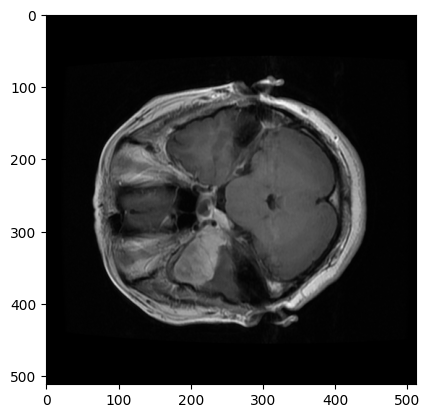

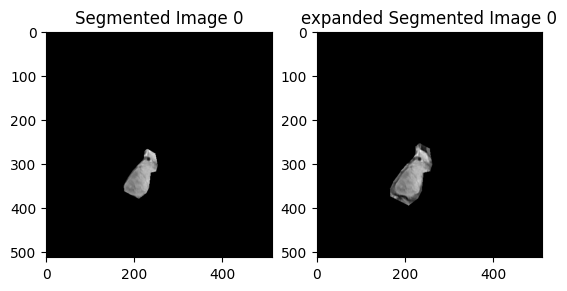

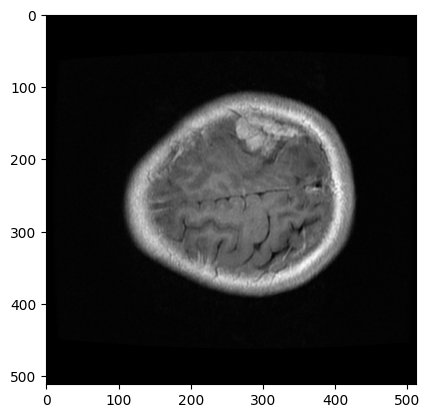

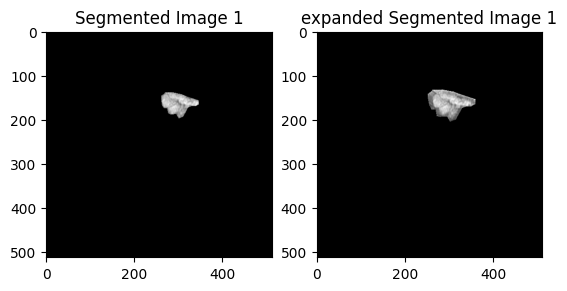

In [ ]:
expanding_factor = 0.25
expanded_segmented_tumor_data = []

for data in all_data:
    image_data = data['image_data']
    tumor_border = data['tumor_border'][0]

    test = np.ones_like(image_data)
    expanded_segmented_region = np.zeros_like(image_data)

    # Extract x and y coordinates from tumor_border
    x_mean = np.mean([int(tumor_border[i]) for i in range(0, len(tumor_border), 2)])
    y_mean = np.mean([int(tumor_border[i + 1]) for i in range(0, len(tumor_border), 2)])
    expanded_x_coords = [int((int(tumor_border[i]) - x_mean)*expanding_factor+int(tumor_border[i]))for i in range(0, len(tumor_border), 2)]
    expanded_y_coords = [int((int(tumor_border[i+1]) - y_mean)*expanding_factor+int(tumor_border[i+1])) for i in range(0, len(tumor_border), 2)]
    # Create a filled polygon based on the tumor border
    rr, cc = polygon(expanded_y_coords, expanded_x_coords)
    # Ensure the indices are within image bounds
    rr = np.clip(rr, 0, image_data.shape[0] - 1)
    cc = np.clip(cc, 0, image_data.shape[1] - 1)
    # Set the pixels within the polygon to the corresponding values from the original image
    expanded_segmented_region[rr, cc] = test[rr, cc]
    expanded_segmented_region = np.rot90(np.fliplr(expanded_segmented_region))
    # Append the segmented region to the list
    expanded_segmented_tumor_data.append(np.where(expanded_segmented_region == 1,image_data, 0))
# Now you have the segmented images in the 'segmented_images' list
# You can access and process them as needed
for i in range(2):
    image_data = all_data[i]['image_data']
    plt.imshow(image_data,cmap = 'gray')
    plt.show()
    expanded_segmented_image = expanded_segmented_tumor_data[i]
    plt.subplot(1,2,1)
    plt.imshow(segmented_tumor_data[i], cmap='gray')
    plt.title(f"Segmented Image {i}")
    plt.subplot(1,2,2)
    plt.imshow(expanded_segmented_image, cmap='gray')
    plt.title(f"expanded Segmented Image {i}")
    plt.show()
# for i, segmented_image in enumerate(segmented_tumor_data):
#     # Display or save the segmented image
#     for i, expanded_segmented_image in enumerate(expanded_segmented_tumor_data):
#     # Display or save the segmented image
#         plt.subplot(1,2,2)
#         plt.imshow(expanded_segmented_image, cmap='gray')
#         plt.title(f"expanded Segmented Image {i}")
#         plt.subplot(1,2,1)
#         plt.imshow(segmented_image, cmap='gray')
#         plt.title(f"Segmented Image {i}")
#         plt.show()
#         break
#     break

In [ ]:
labels = np.array([item['label'] for item in all_data])
label_mapping = {1: 0, 2: 1, 3: 2}
labels = np.array([label_mapping[label] for label in labels])
print(labels.shape)

tumor_data = ([item['image_data'] for item in all_data])
# plt.imshow(tumor_data[1],cmap='gray')
# plt.show()

tumor_border = ([item['tumor_border'] for item in all_data])

tumor_mask = ([item['tumor_mask'] for item in all_data])

# plt.imshow(tumor_mask[1],cmap='gray')
# plt.show()
# plt.imshow(expanded_segmented_tumor_data[1],cmap='gray')
# plt.show()
print(len(tumor_data))
print(len(tumor_border))
print(len(expanded_segmented_tumor_data))

(3064,)
3064
3064
3064


In [ ]:
data_transforms = transforms.Compose([transforms.ToTensor(),lambda x: x.to(torch.float32)])
expanded_segmented_tumor_data = [data_transforms(image) for image in expanded_segmented_tumor_data]
expanded_segmented_tumor_data = [transforms.Resize((256,256))(image) for image in expanded_segmented_tumor_data]
data_train,data_test,label_train,label_test = train_test_split(expanded_segmented_tumor_data,labels,test_size=0.1)
train_data = list(zip(data_train, label_train))
test_data = list(zip(data_test, label_test))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
print(len(data_train),len(label_train))
print(len(data_test),len(label_test))
print(data_train[0].shape)

batch_size = 10

2757 2757
307 307
torch.Size([1, 256, 256])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

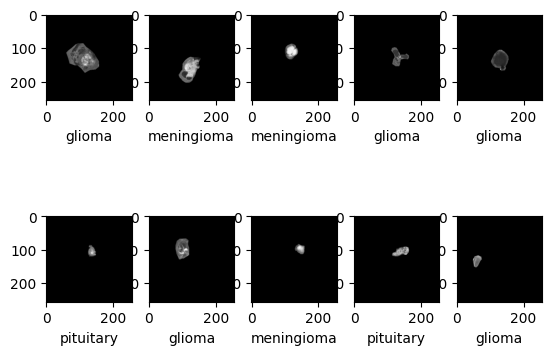

In [ ]:
images,labels = next(iter(train_loader))
i=0
#1 for meningioma, 2 for glioma, 3 for pituitary tumor
classes = {0:'meningioma',1:'glioma',2:'pituitary'}
for i in range(len(images)):
    image = images[i]
    label = labels[i].item()
    i+=1
    plt.subplot(2,5,i)
    plt.imshow(image[0],cmap='gray')
    plt.xlabel(f'{classes[label]}')
plt.show()

In [ ]:
data_loader = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train':2757,'val':307}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
              model.train()  # Set model to training mode
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(torch.long)
                labels = labels.to(device)
                print(inputs.shape)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.0MB/s]


Epoch 1/20
----------
train Loss: 0.7403 Acc: 0.6935
val Loss: 0.5427 Acc: 0.7915
Epoch 2/20
----------
train Loss: 0.6241 Acc: 0.7446
val Loss: 0.5428 Acc: 0.7492
Epoch 3/20
----------
train Loss: 0.5983 Acc: 0.7537
val Loss: 0.4906 Acc: 0.8046
Epoch 4/20
----------
train Loss: 0.5793 Acc: 0.7726
val Loss: 0.4854 Acc: 0.7752
Epoch 5/20
----------
train Loss: 0.5773 Acc: 0.7650
val Loss: 0.4624 Acc: 0.8274
Epoch 6/20
----------
train Loss: 0.5184 Acc: 0.7962
val Loss: 0.4779 Acc: 0.8176
Epoch 7/20
----------
train Loss: 0.5660 Acc: 0.7766
val Loss: 0.6095 Acc: 0.7524
Epoch 8/20
----------
train Loss: 0.5114 Acc: 0.7936
val Loss: 0.4334 Acc: 0.8111
Epoch 9/20
----------
train Loss: 0.4879 Acc: 0.8059
val Loss: 0.4390 Acc: 0.8534
Epoch 10/20
----------
train Loss: 0.4796 Acc: 0.8128
val Loss: 0.4264 Acc: 0.8469
Epoch 11/20
----------
train Loss: 0.4838 Acc: 0.8089
val Loss: 0.4355 Acc: 0.8502
Epoch 12/20
----------
train Loss: 0.4795 Acc: 0.8147
val Loss: 0.4237 Acc: 0.8502
Epoch 13/20
-

In [ ]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

In [ ]:


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 3)  # Output classes: meningioma, glioma, pituitary tumor
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass

        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.maxpool4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Instantiate the model
model = CustomCNN()

# Test the model with a sample input
sample_input = torch.randn((10, 1, 256, 256))
output = model(sample_input)
print("Output shape:", output.shape)
print(model)


RuntimeError: ignored

In [ ]:


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 3)  # Output classes: meningioma, glioma, pituitary tumor
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass

        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.maxpool4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

# Instantiate the model
model = CustomCNN()

# Test the model with a sample input
sample_input = torch.randn((10, 1, 256, 256))
output = model(sample_input)
print("Output shape:", output.shape)
print(model)


In [ ]:
model_conv = CustomCNN()

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------
torch.Size([10, 1, 256, 256])


RuntimeError: ignored